In [1]:
from pandas import Series

# Corrected function for train-test split
def series_train_test_split(data: Series, trn_pct: float = 0.90) -> tuple[Series, Series]:
    if not isinstance(data, Series):
        raise ValueError("Input data must be a pandas Series.")
    trn_size: int = int(len(data) * trn_pct)
    train: Series = data.iloc[:trn_size]  # Use one-dimensional indexing
    test: Series = data.iloc[trn_size:]
    return train, test


In [2]:
from pandas import read_csv, DataFrame, Series

# File details
filename: str = "/Users/dominikfrank/Library/Mobile Documents/com~apple~CloudDocs/Desktop/University/Master/Semester 1/PII/Data Science/Code for Project/DataScience/forecast_gdp_europe.csv"
file_tag: str = "GDP_Europe"
target: str = "GDP"
timecol: str = "Year"

# Load the dataset
data: DataFrame = read_csv(
    filename,
    sep=",",  # Semicolon-separated values
    decimal=".",  # Use period for decimal
    parse_dates=[timecol],  # Parse the Date column
    infer_datetime_format=True,
)

# Check the structure of the data
print(data.info())  # Ensure that `target` is a column and `timecol` is parsed as datetime

# Set the Date column as the index
data.set_index(timecol, inplace=True)

# Extract the target series
series: Series = data[target]

# Check if the series is properly extracted
if not isinstance(series, Series):
    raise ValueError(f"Expected a Series, but got {type(series)}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Year                        58 non-null     datetime64[ns]
 1   Birth_rate                  58 non-null     float64       
 2   CO2_emissions               55 non-null     float64       
 3   Death_rate                  58 non-null     float64       
 4   Electric_power_consumption  55 non-null     float64       
 5   Energy_use                  56 non-null     float64       
 6   Food_exports                56 non-null     float64       
 7   Food_imports                56 non-null     float64       
 8   Goods_services_exports      57 non-null     float64       
 9   Goods_services_imports      57 non-null     float64       
 10  Population_density          57 non-null     float64       
 11  GDP                         58 non-null     float64       
d

/var/folders/r8/55mn588571z9y3flsnt4y5q00000gn/T/ipykernel_28039/3423330843.py:10: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data: DataFrame = read_csv(


In [3]:
# Perform train-test split
train, test = series_train_test_split(series, trn_pct=0.90)

# Check train and test sizes
print(f"Train size: {len(train)}, Test size: {len(test)}")


Train size: 52, Test size: 6


In [11]:
from numpy import mean
from pandas import Series
from sklearn.base import RegressorMixin
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_line_chart

# Rolling Mean Regressor
class RollingMeanRegressor(RegressorMixin):
    def __init__(self, win: int = 3):
        super().__init__()
        self.win_size = win
        self.memory: list = []

    def fit(self, X: Series):
        self.memory = X.iloc[-self.win_size:].tolist()  # Store the last `win_size` values
        return self

    def predict(self, X: Series) -> Series:
        estimations = self.memory[:]
        for _ in range(len(X)):
            if len(estimations) < self.win_size:
                new_value = mean(estimations)  # Use mean of available values
            else:
                new_value = mean(estimations[-self.win_size:])  # Calculate rolling mean
            estimations.append(new_value)
        prd_series: Series = Series(estimations[-len(X):], index=X.index)  # Match test data length
        return prd_series

# Rolling Mean Study
def rolling_mean_study(train: Series, test: Series, measure: str = "R2"):
    win_size = (12, 24, 48, 96, 192, 384, 768)  # Window sizes to evaluate
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Rolling Mean", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for w in win_size:
        pred = RollingMeanRegressor(win=w)
        pred.fit(train)
        prd_tst = pred.predict(test)

        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (w,)
            best_model = pred
        yvalues.append(eval)

    # Log the best window size and performance
    print(f"Rolling Mean best with win={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        win_size, yvalues, title=f"Rolling Mean ({measure})", xlabel="window size", ylabel=measure, percentage=flag
    )

    return best_model, best_params


Rolling Mean best with win=12 -> R2=-7.556586133343211


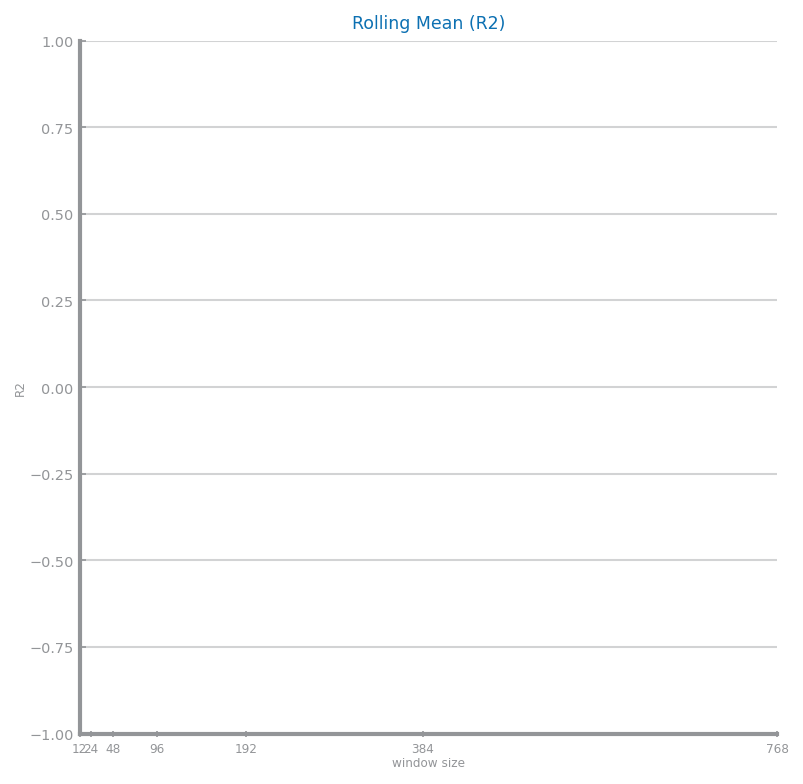

In [12]:
from matplotlib.pyplot import figure, savefig

# Run the rolling mean study
fig = figure(figsize=(6, 6))  # Adjust the figure size if needed
best_model, best_params = rolling_mean_study(train, test, measure="R2")

# Save the study plot
savefig(f"images/{file_tag}_rollingmean_R2_study.png")


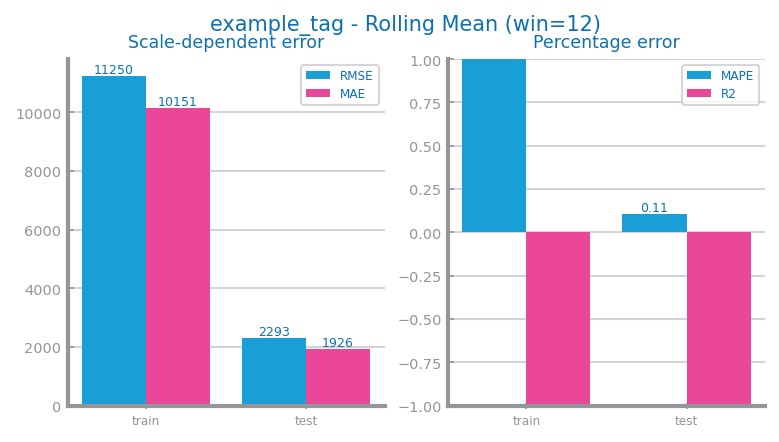

In [13]:
from dslabs_functions import plot_forecasting_eval

# Get the best window size
params = best_params["params"]

# Generate predictions
prd_trn: Series = best_model.predict(train)
prd_tst: Series = best_model.predict(test)

# Evaluate the model
plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Rolling Mean (win={params[0]})")
savefig(f"images/{file_tag}_rollingmean_R2_win{params[0]}_eval.png")


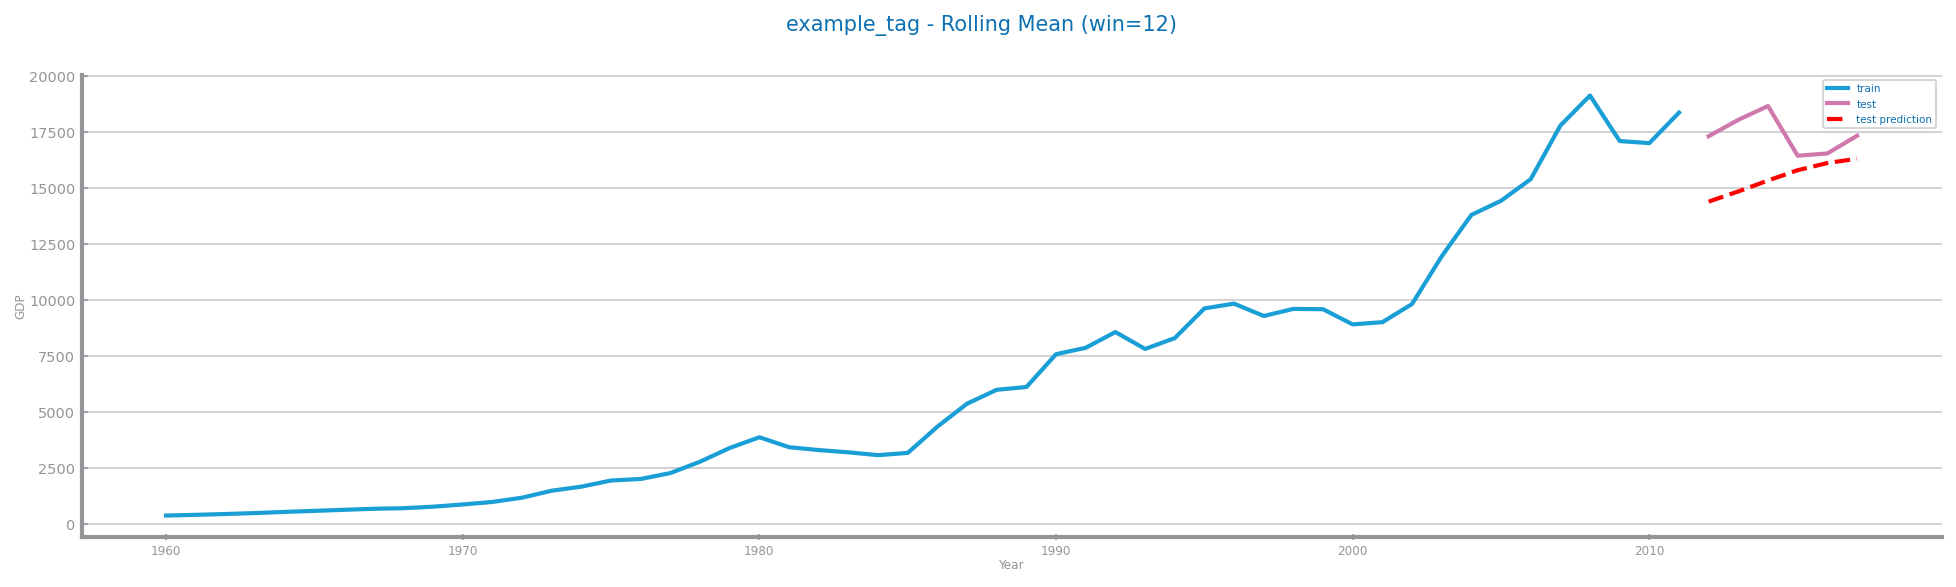

In [14]:
from dslabs_functions import plot_forecasting_series

# Visualize the train, test, and predictions
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Rolling Mean (win={params[0]})",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_rollingmean_R2_forecast.png")
